In [55]:

%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:

base_dir = Path().resolve().parent
inputs_dir = base_dir / "data"
notebook_dir = base_dir / "notebooks"
src_dir = base_dir / "src"

for dir in [base_dir, inputs_dir, notebook_dir, src_dir]:
    dir.mkdir(parents=True, exist_ok=True)
    sys.path.insert(0, str(dir.resolve()))
    

In [57]:
df_amazon = pd.read_csv(inputs_dir / 'raw/amazon_reviews.csv')
df_imdb = pd.read_csv(inputs_dir / 'raw/imdb_reviews.csv')
print(f"Amazon: {df_amazon.shape} | IMDB: {df_imdb.shape}")
print("Vérification : Volume par source OK — prêt à fusionner.")

Amazon: (10000, 3) | IMDB: (5000, 2)
Vérification : Volume par source OK — prêt à fusionner.


In [58]:
df_amazon = df_amazon.rename(columns={'content': 'text', 'label': 'sentiment'})
df_imdb = df_imdb.rename(columns={'text': 'text', 'label': 'sentiment'})

df_all = pd.concat([df_amazon, df_imdb], ignore_index=True)
df_all['text'] = df_all['text'].astype(str).str.strip()


In [59]:




print(f"Total merged: {len(df_all)}")
print("Vérification : Jeu fusionné prêt — pas de doublons détectés ici.")


Total merged: 15000
Vérification : Jeu fusionné prêt — pas de doublons détectés ici.


In [60]:
df_all['n_sentences'] = df_all['text'].str.count(r'\.') + 1
df_all['n_words'] = df_all['text'].str.split().str.len()
df_all['n_chars'] = df_all['text'].str.len()
df_all['avg_word_len'] = df_all['n_chars'] / df_all['n_words'].replace(0, 1)
df_all['n_unique_words'] = df_all['text'].apply(lambda x: len(set(re.findall(r'\w+', str(x).lower()))))
df_all['lexical_density'] = df_all['n_unique_words'] / df_all['n_words'].replace(0, 1)

print(df_all[['n_sentences', 'n_words', 'n_chars', 'avg_word_len', 'lexical_density']].describe())
print("Vérification : Statistiques basiques OK — pas de longueur nulle.")

        n_sentences       n_words       n_chars  avg_word_len  lexical_density
count  15000.000000  15000.000000  15000.000000  15000.000000     15000.000000
mean       8.982933    126.979533    708.291467      5.518312         0.747952
std        7.525912    126.069656    722.647114      0.429669         0.118393
min        1.000000      7.000000     53.000000      3.923077         0.090909
25%        5.000000     51.000000    277.000000      5.236111         0.668449
50%        7.000000     96.000000    528.000000      5.504467         0.741573
75%       11.000000    150.000000    834.000000      5.771485         0.826087
max      122.000000   1522.000000   8969.000000      8.909091         1.350000
Vérification : Statistiques basiques OK — pas de longueur nulle.


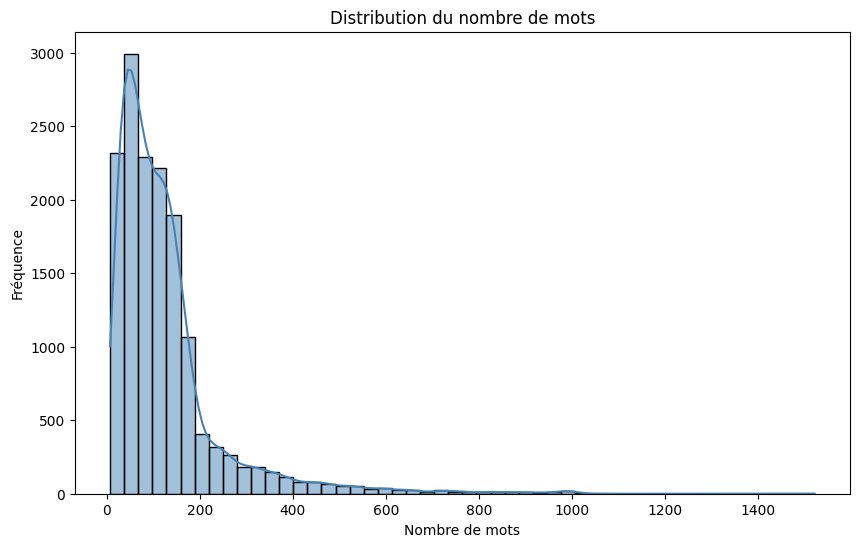

Vérification : Distribution — je vérifie la normalité et la présence d’outliers éventuels.


In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(df_all['n_words'], bins=50, kde=True, color="steelblue")
plt.title('Distribution du nombre de mots')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.show()
print("Vérification : Distribution — je vérifie la normalité et la présence d’outliers éventuels.")


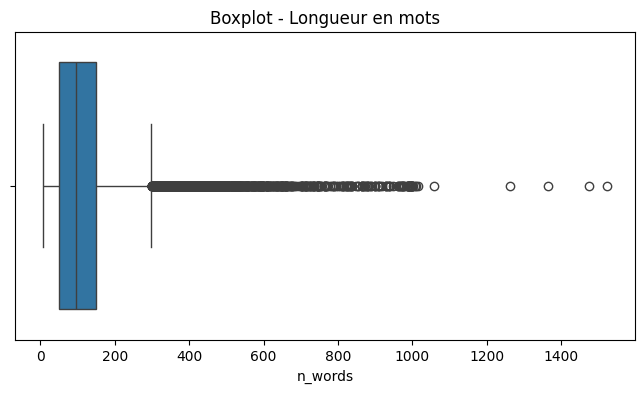

Ici, je contrôle s’il faut filtrer ou normaliser les textes très longs.


In [62]:

plt.figure(figsize=(8, 4))
sns.boxplot(x=df_all['n_words'])
plt.title('Boxplot - Longueur en mots')
plt.show()
print("Ici, je contrôle s’il faut filtrer ou normaliser les textes très longs.")


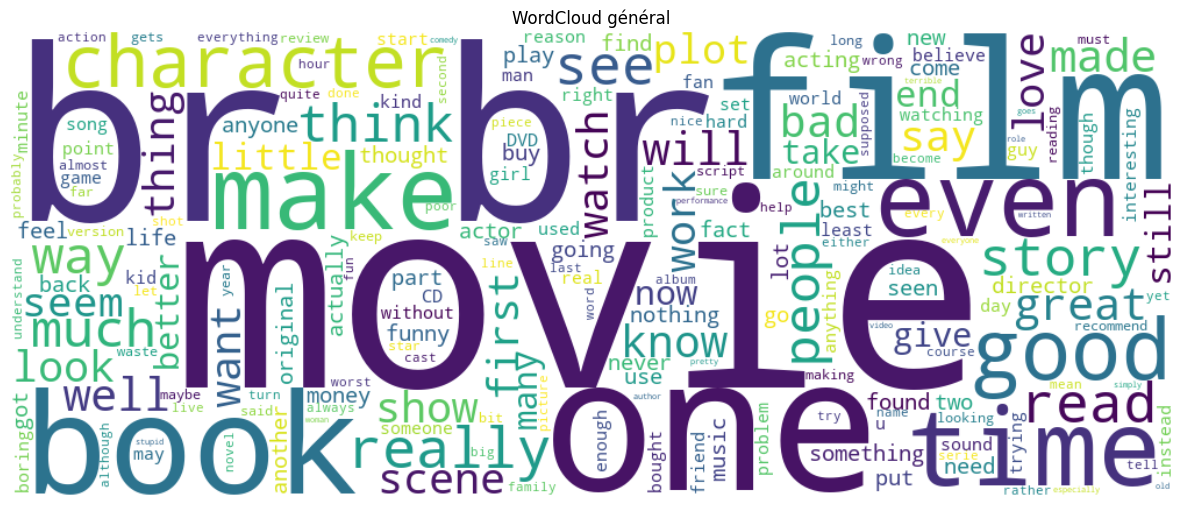

Le wordcloud donne une vue rapide des mots dominants.


In [63]:
all_text = ' '.join(df_all['text'])
wc = WordCloud(width=1000, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud général')
plt.show()
print("Le wordcloud donne une vue rapide des mots dominants.")

In [64]:
all_words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(all_words)
top_20 = word_counts.most_common(20)

print("TOP 20 mots :")
for word, freq in top_20:
    print(f"{word}: {freq}")
print("Vérifier s’il y a du bruit (mots trop génériques).")

TOP 20 mots :
the: 104721
a: 51266
and: 50705
to: 46180
of: 43752
i: 41150
it: 37176
is: 34073
this: 31280
in: 27232
that: 23385
br: 21162
s: 18034
was: 17735
for: 16641
but: 14292
you: 13861
with: 13700
t: 13172
as: 12566
Vérifier s’il y a du bruit (mots trop génériques).


C:\Users\beedi.goua_square-ma\AppData\Local\Temp\ipykernel_6240\2581782300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_df, x='count', y='word', palette='viridis')


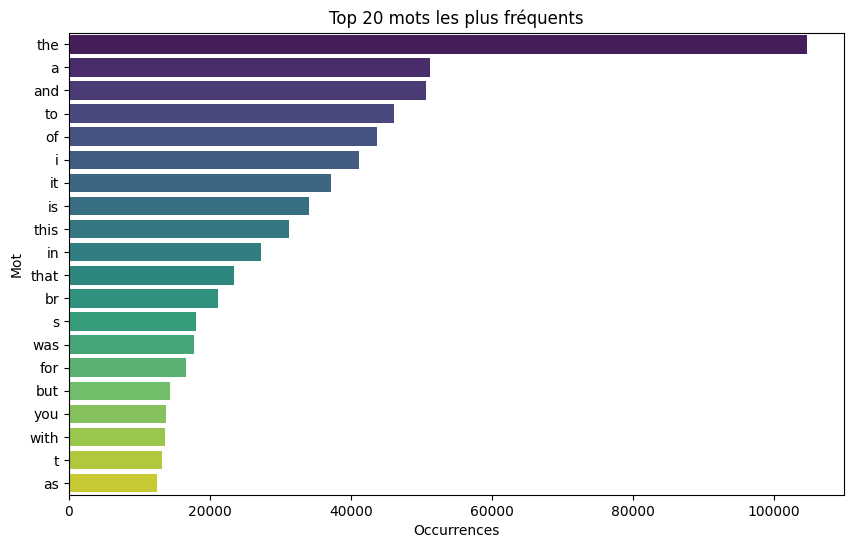

In [65]:
top_words_df = pd.DataFrame(top_20, columns=['word', 'count'])
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='count', y='word', palette='viridis')
plt.title("Top 20 mots les plus fréquents")
plt.xlabel("Occurrences")
plt.ylabel("Mot")
plt.show()


In [66]:
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20, stop_words='english')
X2 = vectorizer.fit_transform(df_all['text'])
bigrams = vectorizer.get_feature_names_out()
counts = X2.sum(axis=0).A1

bigrams_df = pd.DataFrame({'bigram': bigrams, 'count': counts}).sort_values(by='count', ascending=False)
print("TOP bigrams :")
print(bigrams_df)
print("Je regarde les paires de mots dominantes — indicateur de thèmes ou expressions fréquentes.")


TOP bigrams :
             bigram  count
0             br br  10601
15          ve seen    569
13        read book    517
17       waste time    431
18         year old    408
14  special effects    406
3          don know    372
8        looks like    333
2          br movie    301
12       movie just    284
11         movie br    282
9        low budget    278
1           br film    264
6           film br    250
16      waste money    248
4         don think    238
19        years ago    236
5         don waste    232
10   main character    231
7       high school    227
Je regarde les paires de mots dominantes — indicateur de thèmes ou expressions fréquentes.


C:\Users\beedi.goua_square-ma\AppData\Local\Temp\ipykernel_6240\1469534506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigrams_df, x='count', y='bigram', palette='magma')


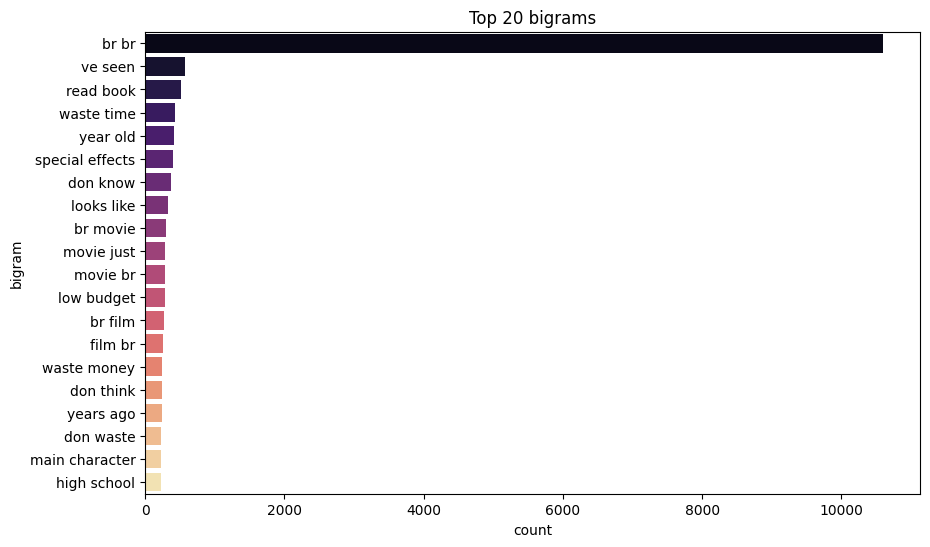

In [67]:


plt.figure(figsize=(10, 6))
sns.barplot(data=bigrams_df, x='count', y='bigram', palette='magma')
plt.title("Top 20 bigrams")
plt.show()


In [68]:

tfidf = TfidfVectorizer(max_features=20, stop_words='english')
X_tfidf = tfidf.fit_transform(df_all['text'])
tfidf_words = tfidf.get_feature_names_out()
tfidf_scores = X_tfidf.sum(axis=0).A1


In [69]:

tfidf_df = pd.DataFrame({'word': tfidf_words, 'tfidf': tfidf_scores}).sort_values(by='tfidf', ascending=False)
print("TOP TF-IDF mots :")
print(tfidf_df)
print("TF-IDF met en valeur des mots plus spécifiques que la simple fréquence brute.")



TOP TF-IDF mots :
      word        tfidf
3       br  2203.770953
2     book  2105.559096
12   movie  2087.082156
10    like  1585.443798
9     just  1525.466396
6     film  1365.383801
7     good  1349.480817
8    great  1191.031811
18    time  1180.795337
14    read  1058.947275
15  really  1036.214842
5      don   982.531992
16   story   840.192674
0      bad   806.636742
1   better   757.266668
11    make   740.398967
4      did   734.776720
19     way   727.564034
13  people   690.662397
17   think   676.583519
TF-IDF met en valeur des mots plus spécifiques que la simple fréquence brute.


C:\Users\beedi.goua_square-ma\AppData\Local\Temp\ipykernel_6240\1107088399.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tfidf_df, x='tfidf', y='word', palette='coolwarm')


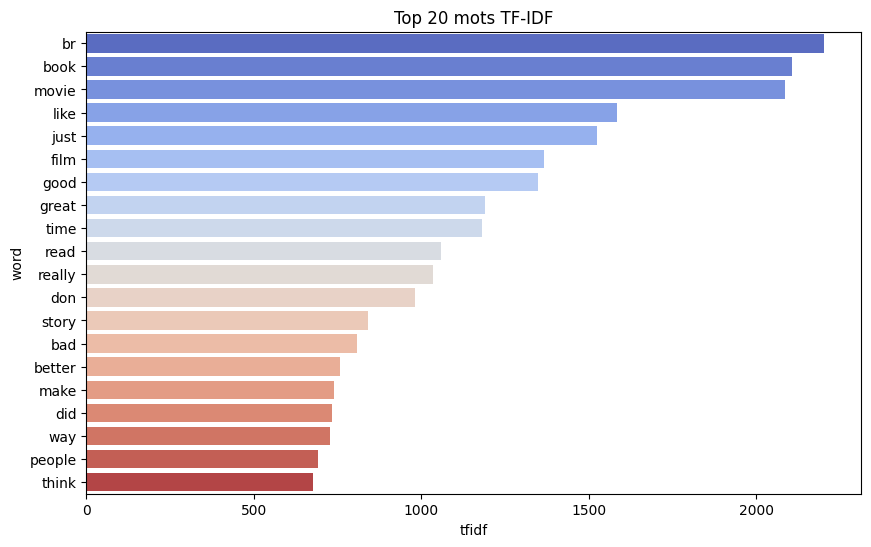

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=tfidf_df, x='tfidf', y='word', palette='coolwarm')
plt.title("Top 20 mots TF-IDF")
plt.show()

sentiment
0    10097
1     4903
Name: count, dtype: int64
sentiment
0    67.313333
1    32.686667
Name: proportion, dtype: float64


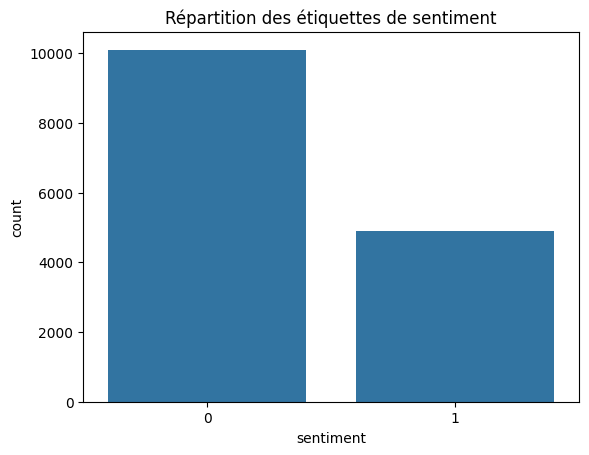

Vérifier l’équilibre des classes pour le futur modèle.


In [71]:
if 'sentiment' in df_all.columns:
    print(df_all['sentiment'].value_counts())
    print(df_all['sentiment'].value_counts(normalize=True) * 100)
    sns.countplot(data=df_all, x='sentiment')
    plt.title("Répartition des étiquettes de sentiment")
    plt.show()
    print("Vérifier l’équilibre des classes pour le futur modèle.")


Avis potentiellement toxiques : 2886
💡 Ceci donne une première approximation brute de toxicité.


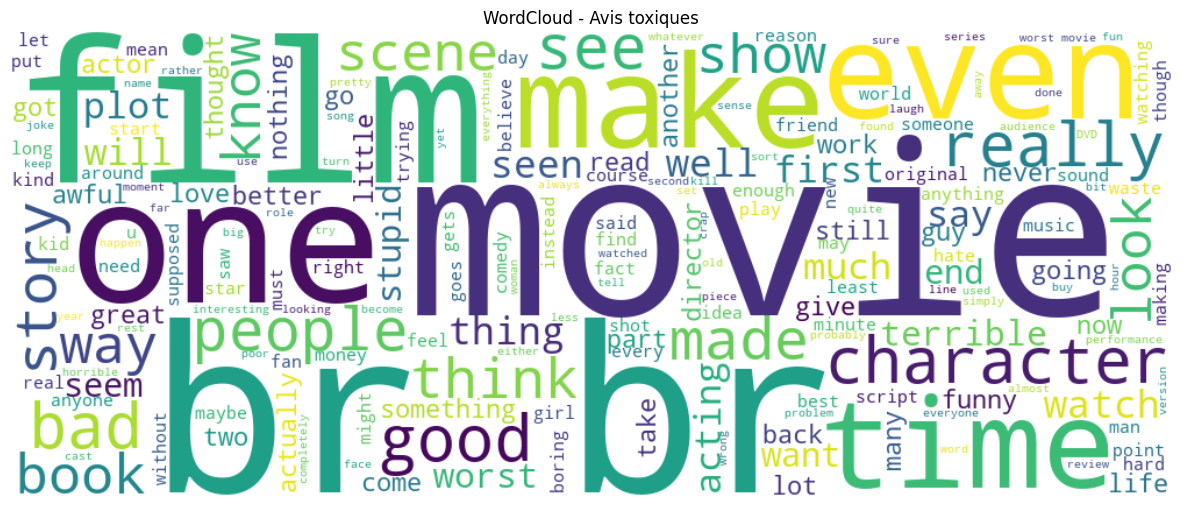

In [72]:



toxics = ['hate', 'terrible', 'worst', 'awful', 'disgusting', 'stupid']
df_all['potential_toxic'] = df_all['text'].str.lower().str.contains('|'.join(toxics))
print(f"Avis potentiellement toxiques : {df_all['potential_toxic'].sum()}")
print("💡 Ceci donne une première approximation brute de toxicité.")

toxic_texts = df_all[df_all['potential_toxic']]['text']
if len(toxic_texts) > 0:
    wc_toxic = WordCloud(width=1000, height=400, background_color='white').generate(' '.join(toxic_texts))
    plt.figure(figsize=(15, 7))
    plt.imshow(wc_toxic, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud - Avis toxiques')
    plt.show()


                  n_words   n_chars  n_sentences  lexical_density  \
n_words          1.000000  0.997439     0.820006        -0.710325   
n_chars          0.997439  1.000000     0.818514        -0.688945   
n_sentences      0.820006  0.818514     1.000000        -0.605866   
lexical_density -0.710325 -0.688945    -0.605866         1.000000   
potential_toxic  0.344631  0.339828     0.322540        -0.282092   

                 potential_toxic  
n_words                 0.344631  
n_chars                 0.339828  
n_sentences             0.322540  
lexical_density        -0.282092  
potential_toxic         1.000000  


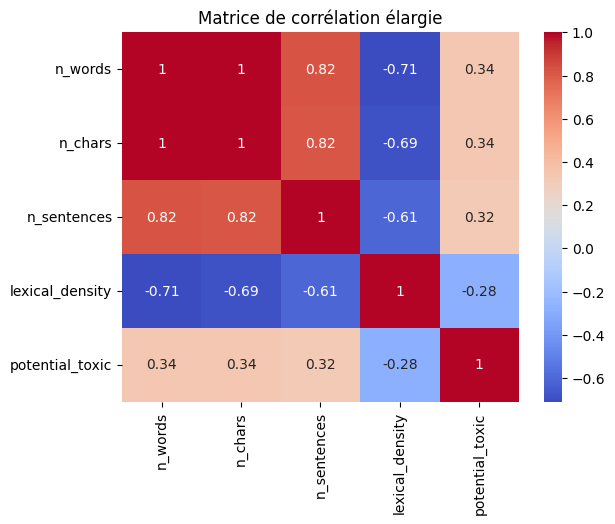

 Heatmap : permet de détecter les liens entre complexité, longueur et toxicité.


In [73]:
# CORRÉLATION & HEATMAP

corr_matrix = df_all[['n_words', 'n_chars', 'n_sentences', 'lexical_density', 'potential_toxic']].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation élargie")
plt.show()
print(" Heatmap : permet de détecter les liens entre complexité, longueur et toxicité.")


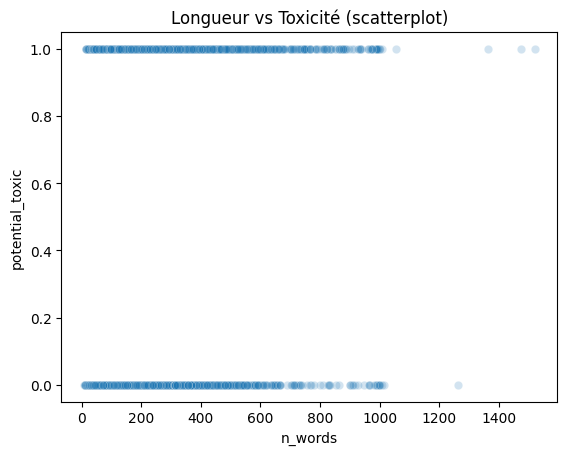

In [74]:

# SCATTERPLOT LONGUEUR VS TOXICITÉ

sns.scatterplot(data=df_all, x='n_words', y='potential_toxic', alpha=0.2)
plt.title("Longueur vs Toxicité (scatterplot)")
plt.show()



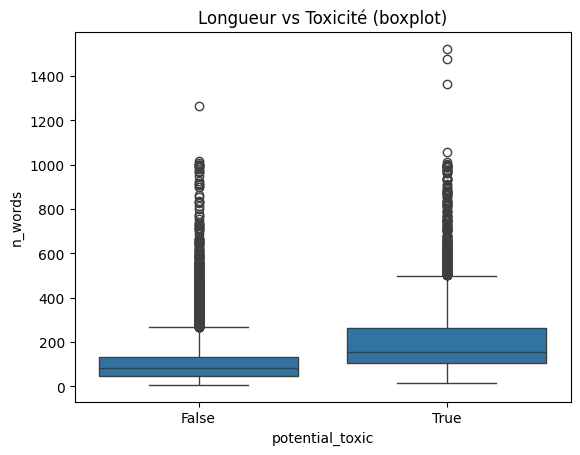

In [79]:
sns.boxplot(x='potential_toxic', y='n_words', data=df_all)
plt.title("Longueur vs Toxicité (boxplot)")
plt.show()


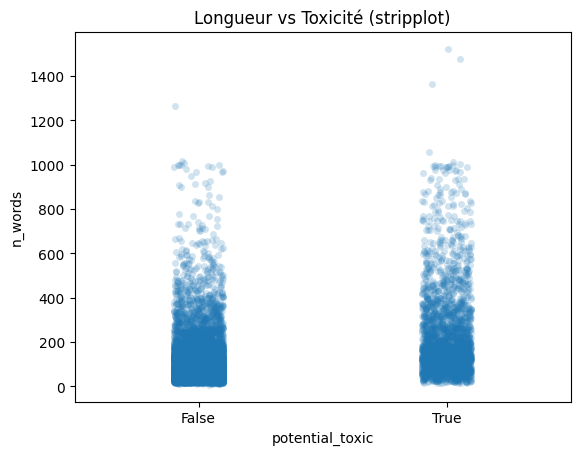

In [80]:
sns.stripplot(x='potential_toxic', y='n_words', data=df_all, alpha=0.2)
plt.title("Longueur vs Toxicité (stripplot)")
plt.show()


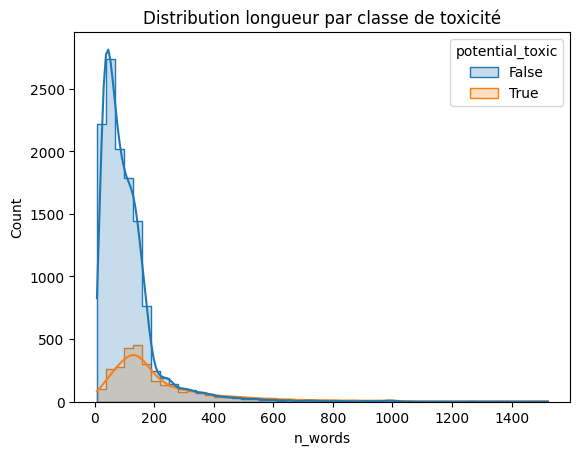

In [81]:
sns.histplot(data=df_all, x='n_words', hue='potential_toxic', bins=50, kde=True, element="step")
plt.title("Distribution longueur par classe de toxicité")
plt.show()


In [75]:

# TOP PHRASES LONGUES

top_long = df_all.sort_values('n_words', ascending=False).head(5)
print(top_long[['text','n_words']])
print("Vérifier ces outliers à la main pour détecter du spam, du bruit ou du contenu anormal.")


                                                    text  n_words
12037  Some have praised _Atlantis:_The_Lost_Empire_ ...     1522
12038  Some have praised -Atlantis:-The Lost Empire- ...     1475
13034  This movie was recently released on DVD in the...     1364
11127  Raising Victor Vargas: A Review<br /><br />You...     1263
14593  ***SPOILERS*** ***SPOILERS*** Continued...<br ...     1057
Vérifier ces outliers à la main pour détecter du spam, du bruit ou du contenu anormal.


In [76]:

# FLAG MAUVAIS MOTS AVANCÉ

bad_words = [
    'hate', 'terrible', 'worst', 'stupid', 'idiot', 'trash', 'garbage',
    'fuck', 'fucked', 'fucking', 'shit', 'shitty', 'bitch', 'bitches',
    'dumb', 'crap', 'bullshit', 'asshole', 'bastard', 'moron', 'sucks',
    'suck', 'loser', 'jerk', 'damn', 'damned', 'retard', 'retarded',
    'whore', 'slut', 'piss', 'pissed', 'screw', 'screwed'
]
bad_pattern = r'\b(?:' + '|'.join(bad_words) + r')\b'
df_all['flag_badwords'] = df_all['text'].str.lower().apply(lambda x: bool(re.search(bad_pattern, x)))
print(f"Nombre d'avis avec mots injurieux détectés : {df_all['flag_badwords'].sum()}")
print("Regex plus complet pour identifier vocabulaire injurieux large.")


Nombre d'avis avec mots injurieux détectés : 3080
Regex plus complet pour identifier vocabulaire injurieux large.


In [77]:

# SAUVEGARDE CSV FINAL

df_all.to_csv(inputs_dir / 'processed/merged_reviews_eda.csv', index=False)
print("Fichier enrichi sauvegardé : merged_reviews_eda.csv")

Fichier enrichi sauvegardé : merged_reviews_eda.csv
